In [4]:
! ls datasets/bitcoin

bitcoin_data.csv


In [115]:
import torch
import torch.nn as nn
import torch.utils 
import torch.utils.data
from torch.autograd import Variable
import os
from datetime import datetime
import pandas
import numpy as np
from sklearn.preprocessing import MinMaxScaler
df=pandas.read_csv('datasets/bitcoin/data.csv')

In [39]:
print(df.shape)
df.head()

(365, 1)


,price
0,1723.126937
1,1739.031975
2,1807.485062
3,1899.082887
4,1961.520487


In [203]:
test_days = 90
numdays=7 # number of days to look back
df_train= df[:len(df)-test_days]
df_test= df[len(df)-test_days:]
training_set = df_train.values
test_set = df_test.values
transformer= MinMaxScaler().fit(training_set)
training_set =transformer.transform(training_set)
test_set = df_test.values
test_set = transformer.transform(test_set)

x_train=[];y_train=[];
x_test=[];y_test=[];
for i in range(len(training_set)-numdays):
    x_train.append(training_set[i:(i+numdays)])
    y_train.append(training_set[i+numdays])
for i in range(len(test_set)-numdays):
    x_test.append(test_set[i:(i+numdays)])
    y_test.append(test_set[i+numdays])
x_train=torch.from_numpy(np.array(x_train).squeeze().astype(np.float32))
y_train=torch.from_numpy(np.array(y_train).astype(np.float32))
x_test=torch.from_numpy(np.array(x_test).squeeze().astype(np.float32))
#y_test=torch.from_numpy(np.array(y_test).astype(np.float32))

print(x_train.shape, x_test.shape)


torch.Size([268, 7]) torch.Size([83, 7])


In [204]:
class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # using a GRU (Gated Recurrent Unit), also try and LSTM
        self.rnn1 = nn.GRU(input_size=7, hidden_size=8, num_layers=1)
        self.dropout = nn.Dropout(p=0.20)
        self.dense1 = nn.Linear(8, 4)
        self.dense2 = nn.Linear(4, 1)

    def forward(self, x, hidden):
        x_batch = x.view(len(x), 1, -1)
        x_r, hidden = self.rnn1(x_batch, hidden)
        x_d = self.dropout(x_r)
        x_l = self.dense1(x_d)
        x_l2 = self.dense2(x_l)
        return x_l2, hidden

    def init_hidden(self):
        return Variable(torch.randn(1, 1, 8))

In [205]:
model = MyModel()
lossfn = nn.MSELoss()
optimizer = torch.optim.Adadelta(model.parameters(), lr=0.1)
initial_hidden = model.init_hidden()
print(model)

MyModel(
  (rnn1): GRU(7, 8)
  (dropout): Dropout(p=0.2)
  (dense1): Linear(in_features=8, out_features=4, bias=True)
  (dense2): Linear(in_features=4, out_features=1, bias=True)
)


In [206]:

for i in range(700):
    model.zero_grad()
    hidden=initial_hidden
    out, hidden = model(x_train, hidden)
    loss = lossfn(out.view(-1,1), y_train)
    if i % 20 == 0:
        print('{:%H:%M:%S} epoch {} loss: {}'.format(datetime.now(), i, loss.data.numpy().tolist()), flush=True)
    loss.backward()
    optimizer.step()

16:28:22 epoch 0 loss: 0.29302483797073364
16:28:24 epoch 20 loss: 0.20117031037807465
16:28:25 epoch 40 loss: 0.1332092583179474
16:28:26 epoch 60 loss: 0.08293527364730835
16:28:27 epoch 80 loss: 0.062131669372320175
16:28:27 epoch 100 loss: 0.03836633265018463
16:28:28 epoch 120 loss: 0.03403342142701149
16:28:29 epoch 140 loss: 0.023084308952093124
16:28:30 epoch 160 loss: 0.025196565315127373
16:28:31 epoch 180 loss: 0.019430482760071754
16:28:32 epoch 200 loss: 0.019429434090852737
16:28:33 epoch 220 loss: 0.015589768998324871
16:28:34 epoch 240 loss: 0.02108396776020527
16:28:34 epoch 260 loss: 0.018058326095342636
16:28:35 epoch 280 loss: 0.01745813526213169
16:28:36 epoch 300 loss: 0.01740894839167595
16:28:37 epoch 320 loss: 0.011246944777667522
16:28:38 epoch 340 loss: 0.014268566854298115
16:28:39 epoch 360 loss: 0.012683102861046791
16:28:40 epoch 380 loss: 0.012726694345474243
16:28:42 epoch 400 loss: 0.010765285231173038
16:28:42 epoch 420 loss: 0.013534728437662125
16:2

In [207]:
# Training set
pred, new_hidden = model(x_train, initial_hidden)
prices=transformer.inverse_transform(pred.detach().numpy().reshape(-1,1))
actual=transformer.inverse_transform(y_train.numpy().reshape(-1,1))

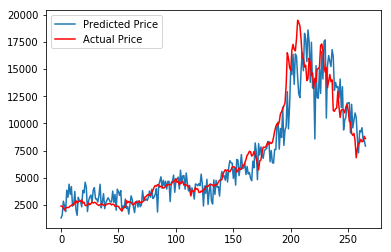

In [208]:
import matplotlib.pyplot as plt
plt.plot(range(prices.shape[0]-2), prices[2:], label='Predicted Price')
plt.plot(range(prices.shape[0]-2), actual[2:], 'r', label='Actual Price')
plt.legend()
plt.show()

In [209]:
# Training set
pred, new_hidden = model(x_test, initial_hidden)
prices=transformer.inverse_transform(pred.detach().numpy().reshape(-1,1))
actual=transformer.inverse_transform(y_test)

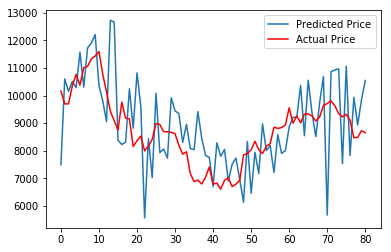

In [210]:
import matplotlib.pyplot as plt
plt.plot(range(prices.shape[0]-2), prices[2:], label='Predicted Price')
plt.plot(range(prices.shape[0]-2), actual[2:], 'r', label='Actual Price')
plt.legend()
plt.show()